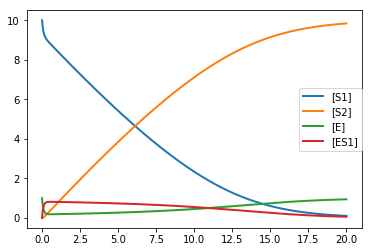

In [79]:
# example-2a: enzyme
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

te.setDefaultPlottingEngine('matplotlib')

modelA = """
model test
    compartment C1;
    C1 = 1.0;
    species S1, S2, E, ES1;

    S1 = 10.0;
    S2 = 0.0;
    E = 1.0;
    ES1 = 0.0;
    S1 in C1; S2 in C1; E in C1; ES1 in C1;
    J1: S1 + E -> ES1; S1*E*kf;  #fwd
    J2: ES1 -> S1 + E; ES1*kr;  #rwd
    J3: ES1 -> S2 + E; ES1*kc;   #catalytic

    kf = 1.0; kr = 1.0; kc = 1.0;
end
"""
# load models
rDefault = te.loada(modelA)


# simulate from 0 to 50 with 100 steps
rDefault.simulate(0, 20, 500)
# plot the simulation
rDefault.plot()

In [80]:
# parameter scan simulation 
def paramScan(param, paramRange, r, prod, Tmax):
    r.reset() # re-seting simulation result
    m = r.simulate (0, Tmax, 5*Tmax, selections=["time"]) #make time array
    for i in range(0,len(paramRange)):
        r.reset()
        r[param] = paramRange[i]
        res = r.simulate(0, Tmax, 5*Tmax, selections=[prod])
        m = np.concatenate([m, res], axis=1)
    return m 

# initial velocity estimation
def initV(simResult):
    initM = simResult[0, 1:]  # initial product [S2]
    finalM = simResult[-1,1:] # final product [S2]
    timecourseM = simResult[:,1:] # timecourse [S2]
    
    #find the differences between 1/2 [S2]max and each timcourse [S2] 
    #the minimal absolute difference would be where [S2] ~ 1/2 [S2]max
    diffMmid = abs(timecourseM-(finalM/2)) 
    # find that minimum difference values
    minInColumns = np.amin(diffMmid, axis=0)
    # find the index where where [S2] ~ 1/2 [S2]max
    ind = np.where(minInColumns == diffMmid)[0] # index of mid time
    timepoint = simResult[:, 0] # time point array from time course simulation 
    thalf = timepoint[ind] # time point when [S2] ~ 1/2 [S2]max
    
    # estimate initial reaction velocity
    Vinit = ((finalM/2) - initM) / thalf
    
    return Vinit

def lineweaverBurk(Vinit, Sinit):
    inv_S1 = np.power(S1range,-1) # calculate 1/[S1]
    inv_Vinit = np.power(Vinit,-1) # calculate 1/[Vinit]
    
    # Linear Regression Curve Fitting
    # https://data36.com/linear-regression-in-python-numpy-polyfit/ 
    model = np.polyfit(inv_S1, inv_Vinit, 1)
    predict = np.poly1d(model)
    x_lin_reg = np.linspace(-max(inv_S1), max(inv_S1), 10)
    y_lin_reg = predict(x_lin_reg)
    
    return inv_S1, inv_Vinit, model, x_lin_reg, y_lin_reg

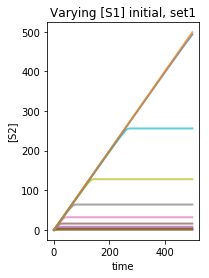

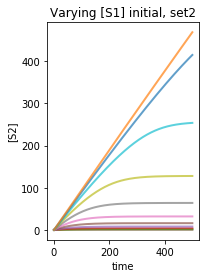

In [81]:
# Try varying S1 initial 
r = rDefault
S1range = [0.5,1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] # range of substrate

m1 = paramScan('[S1]', S1range, r, 'S2', 500)



## additional simulation for comparing the effect of tuning parameters
r2 = rDefault
r2.kr = 50 ## dissociation rate constant

m2 = paramScan('[S1]', S1range, r2, 'S2', 500)



### generate plots 
#plt.subplots(figsize=(12,6 )) # set figure size
plt.subplot(1,2,1)

te.plotArray(m1, alpha=0.7, loc=None,
             xlabel="time", ylabel="[S2]", title="Varying [S1] initial, set1");


#plt.subplots(figsize=(12,6 )) # set figure size
plt.subplot(1,2,2)

te.plotArray(m2, alpha=0.7, loc=None,
             xlabel="time", ylabel="[S2]", title="Varying [S1] initial, set2");


Parameter Set 1:
Vmax = 1.0638411593175274
Km = 4.576207010020367
Parameter Set 2:
Vmax = 0.9900145764129296
Km = 71.26996998208617


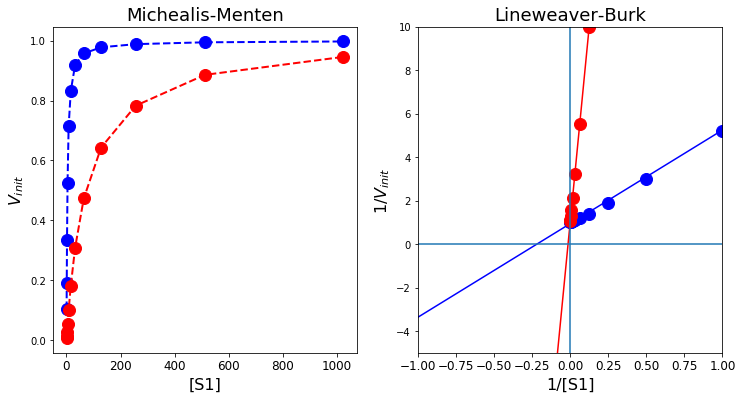

In [82]:
# Michealis-Menten
Vinit = initV(m1)
Vinit2 = initV(m2)


### Lineweaver-Burk
inv_S1, inv_Vinit, model, x_lin_reg, y_lin_reg = lineweaverBurk(Vinit, S1range)
inv_S12, inv_Vinit2, model2, x_lin_reg2, y_lin_reg2 = lineweaverBurk(Vinit2, S1range)



### Print out Vmax & Km
print("Parameter Set 1:")
print("Vmax = " + str(np.power(model[1], -1)))
print("Km = " + str(model[0]/model[1]))
print("Parameter Set 2:")
print("Vmax = " + str(np.power(model2[1], -1)))
print("Km = " + str(model2[0]/model2[1]))



# comparing result from the two simulation
# Michealis-Menten
plt.subplots(figsize=(12,6 )) # set figure size
plt.subplot(1,2,1)

plt.plot(S1range, Vinit, marker='o', linestyle='dashed', color = 'b',
              linewidth=2, markersize=12)

plt.plot(S1range, Vinit2, marker='o', linestyle='dashed', color = 'r',
              linewidth=2, markersize=12)

plt.xlabel("[S1]", fontsize=16)
plt.ylabel("$V_{init}$", fontsize=16)
plt.title("Michealis-Menten", fontsize=18)
plt.xticks(fontsize=12)



# Lineweaver-Burk
plt.subplot(1,2,2)

plt.plot(inv_S1, inv_Vinit, marker='o', linestyle="none", color = 'b',
               markersize=12)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')

plt.plot(inv_S12, inv_Vinit2, marker='o', linestyle="none", color = 'r',
               markersize=12)
plt.plot(x_lin_reg2, y_lin_reg2, c = 'r')

plt.xlabel("1/[S1]", fontsize=16)
plt.ylabel("1/$V_{init}$", fontsize=16)
plt.title("Lineweaver-Burk", fontsize=18)
plt.xticks(fontsize=12)
plt.xlim((-1,1)) # set x-axis range
plt.ylim((-5,10)) # set y-axis range
plt.axvline(x=0) # vertical line at x-axis
plt.axhline(y=0) # horizontal line at y-axis

